# B08705012 HW4

In [2]:
# load packages
%matplotlib inline
import pickle
from sklearn import preprocessing

# Load data
with open('msd_full.pickle', 'rb') as fh1:
    msd_data = pickle.load(fh1)

doscaling = 1
if (doscaling == 1):
    xscaler = preprocessing.StandardScaler().fit(msd_data['X_train'])
    # standardize feature values
    X_train = xscaler.transform(msd_data['X_train'])
    X_test = xscaler.transform(msd_data['X_test'])
else:
    X_train = msd_data['X_train']
    X_test = msd_data['X_test']

Y_train = msd_data['Y_train']
Y_test = msd_data['Y_test'].astype('float32')
X_test = X_test.astype('float32')

y_mean = Y_train.mean()
Y_train_keep = Y_train.copy()
Y_test_keep = Y_test.copy()
Y_train = Y_train - y_mean
Y_test = Y_test - y_mean


# validation is the last 10% of training, subtraining is the first 90% of training
nvalid = int(X_train.shape[0] * 0.1)
nsubtrain = X_train.shape[0] - nvalid

X_subtrain = X_train[0:nsubtrain, :].astype('float32')
X_valid = X_train[nsubtrain:, :].astype('float32')
Y_subtrain = Y_train[0:nsubtrain].astype('float32')
Y_valid = Y_train[nsubtrain:].astype('float32')

Y_subtrain_keep = Y_train_keep[0:nsubtrain].astype('float32')
Y_valid_keep = Y_train_keep[nsubtrain:].astype('float32')

print("X_train shape = ", X_train.shape)
print("X_subtrain shape = ", X_subtrain.shape)
print("X_valid shape = ", X_valid.shape)
print("Y_subtrain shape = ", Y_subtrain.shape)
print("Y_valid shape = ", Y_valid.shape)
print("X_test shape = ", X_test.shape)

X_train shape =  (463715, 90)
X_subtrain shape =  (417344, 90)
X_valid shape =  (46371, 90)
Y_subtrain shape =  (417344,)
Y_valid shape =  (46371,)
X_test shape =  (51630, 90)


## Q1
使用Training資料訓練一個Ordinary Least Square模型，並進行預測。列出此模型的RMSE與前五個特徵的參數。OLS模型應包含常數項，且不應有任何Regularization。

In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

reg = LinearRegression(n_jobs=-1)
reg.fit(X_subtrain, Y_subtrain_keep)
print("First 5 coefficients:", reg.coef_[0:5])
y_pred = reg.test(X_test)


# squared: bool, default=True
# If True returns MSE value, if False returns RMSE value.
print("RMSE = ", mean_squared_error(Y_test_keep, y_pred, squared=False))

First 5 coefficients: [ 5.2934217  -2.8868322  -1.5276358   0.06306767 -0.33957994]
RMSE =  9.509892


## Q2

- 建構一個有四層Hidden Layer的MLP。
- 此模型由輸入層開始，90個Input Features通過線性層轉換為H個Hidden Nodes，
- 通過ReLu Activation Function，此為第一層Hidden Layer。
- 接著通過下一個線性層與ReLu Activation Function，此為第二層。
- 接著下一個線性層與ReLu Activation Function，此為第三層。 
- 然後下一個線性層與ReLu Activation Function，此為第四層。
- 最後通過一個線性層輸出。 所有Hidden Layer的寬度都為H。

令 H= 45, 使用 SGD 更新參數，設 Learning Rate = 0.00001，無 Weight Decay 與 Momentum。畫出模型訓練過程中的 Training 與Validation RMSE，列出 Test RMSE。
並討論訓練過程中 Training 與 Validation RMSE 的圖形意義。

In [18]:
import torch
from torch.utils import data

class Dataset(data.Dataset):
  def __init__(self, X, Y):
        self.labels = Y
        self.len = X.shape[0]
        self.X = X
        self.Y = Y
        

  def __len__(self):
        return self.len

  def __getitem__(self, index):
        X = self.X[index]
        y = self.Y[index]
        return X, y

### Create Dataloader

In [19]:
trainset = Dataset(X_train, Y_train)
subtrainset = Dataset(X_subtrain, Y_subtrain)
validset = Dataset(X_valid, Y_valid)
testset = Dataset(X_test, Y_test)

trainloader = data.DataLoader(trainset, batch_size=1000, shuffle=True, num_workers=0)
subtrainloader = data.DataLoader(subtrainset, batch_size=1000, shuffle=True, num_workers=0)
validloader = data.DataLoader(validset, batch_size=10000, shuffle=True, num_workers=0)
testloader = data.DataLoader(testset, batch_size=10000, shuffle=True, num_workers=0)

### Create Model

In [24]:
def mlp_model(input_size, hidden_size, output_size):
    model = torch.nn.Sequential(
        torch.nn.Linear(input_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size, output_size)
    )
    return model

net = mlp_model(trainset.X.shape[1], 45, 1)

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.float()
net = net.to(device)

optimizer = torch.optim.SGD(net.parameters(), lr=0.00001, momentum=0, weight_decay=0)
loss_func = torch.nn.MSELoss(reduction='sum')

- Minibatch: 1,000個資料點，更新參數之後稱為經歷了一個Batch。
- 當所有 Subtraining 資料已經用來更新過模型參數，稱為經過了一個Epoch。
- 每 100 個 Batch 計算一次 Training and Validation RMSE。
- 如果 Validation 為歷史最低，則記下當下的模型參數與當時已進行的 Batch 數量，稱為best_step_count。
- early_stop 設為 5,000 個 Batch。

In [26]:
from livelossplot import PlotLosses
import numpy as np

def train(net, optimizer, loss_func, trainloader, validloader, epochs=100, patient=5000, model_path='model/result.ckpt', verbose=True):
    '''
    ### Parameters
    - net: model
    - optimizer: optimizer (Adam or SGD)
    - loss_func: loss function
    - trainloader: training data loader
    - validloader: validation data loader
    - epochs: number of epochs
    - patient: number of batches to wait before early stopping
    - verbose: print training progress
    - model_path: path to save model
    '''
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    step_count = 0
    best_step_count = 0
    interval = 100

    train_loss_list = []
    valid_loss_list = []
    best_valid_rmse = float("inf")

    best_net_state = {}
    stop = False

    for epoch in range(epochs):
        if stop:
            break
        for _, (data, target) in enumerate(trainloader):
            step_count += 1
            net.train()
            target = target.reshape((-1, 1))
            data = data.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            output = net(data)
            
            loss = loss_func(output, target)
            loss.backward()
            optimizer.step()

            if step_count % interval == 0:
                net.eval()
                # calculate training loss with current model
                train_loss = 0
                for _, (data, target) in enumerate(trainloader):
                    target = target.reshape((-1, 1))
                    data = data.to(device)
                    target = target.to(device)
                    output = net(data)
                    train_loss += torch.nn.MSELoss(reduction='sum')(output, target).item()
                    
                train_rmse = np.sqrt(train_loss / len(trainloader.dataset))
                train_loss_list.append(train_rmse)      
                
                # calculate validation loss with current model
                valid_loss = 0   
                for _, (data, target) in enumerate(validloader):
                    target = target.reshape((-1, 1))
                    data = data.to(device)
                    target = target.to(device)
                    output = net(data)
                    valid_loss += torch.nn.MSELoss(reduction='sum')(output, target).item()
                
                valid_rmse = np.sqrt(valid_loss / len(validloader.dataset))
                valid_loss_list.append(valid_rmse)

                if verbose:
                    print(f'Epoch {epoch+1:3} | Step {step_count:6} | Train RMSE {train_rmse:7.4f} | Valid RMSE {valid_rmse:7.4f}')
                
                if valid_rmse < best_valid_rmse:
                    best_valid_rmse = valid_rmse
                    best_step_count = step_count
                    best_net_state = net.state_dict()
                    torch.save(net, model_path)
                elif step_count - best_step_count > patient:
                    print("Early stopping at epoch", epoch+1)
                    stop = True
                    break
    return net, best_net_state, train_loss_list, valid_loss_list

In [27]:
model, best_net_state, train_loss_list, valid_loss_list = train(net, optimizer=optimizer, loss_func=loss_func, trainloader=subtrainloader, validloader=validloader, epochs=10, model_path="model/q2.ckpt")

Epoch   1 | Step    100 | Train RMSE  9.5409 | Valid RMSE  9.4925
Epoch   1 | Step    200 | Train RMSE  9.1682 | Valid RMSE  9.1105
Epoch   1 | Step    300 | Train RMSE  8.9394 | Valid RMSE  8.8871
Epoch   1 | Step    400 | Train RMSE  8.8656 | Valid RMSE  8.8165
Epoch   2 | Step    500 | Train RMSE  9.0135 | Valid RMSE  8.9647
Epoch   2 | Step    600 | Train RMSE  8.7771 | Valid RMSE  8.7416
Epoch   2 | Step    700 | Train RMSE  8.7811 | Valid RMSE  8.7575
Epoch   2 | Step    800 | Train RMSE  8.9124 | Valid RMSE  8.8904
Epoch   3 | Step    900 | Train RMSE  8.7000 | Valid RMSE  8.6853
Epoch   3 | Step   1000 | Train RMSE  8.7170 | Valid RMSE  8.7154
Epoch   3 | Step   1100 | Train RMSE  8.6597 | Valid RMSE  8.6508
Epoch   3 | Step   1200 | Train RMSE  8.6565 | Valid RMSE  8.6505
Epoch   4 | Step   1300 | Train RMSE  8.6560 | Valid RMSE  8.6568
Epoch   4 | Step   1400 | Train RMSE  8.6398 | Valid RMSE  8.6507
Epoch   4 | Step   1500 | Train RMSE  8.6508 | Valid RMSE  8.6687
Epoch   4 

[Text(0, 0.5, 'RMSE'), Text(0.5, 0, 'number of batches')]

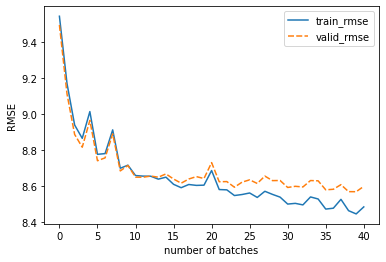

In [28]:
import seaborn as sns
import pandas as pd

df_loss = pd.DataFrame({"train_rmse": train_loss_list, "valid_rmse": valid_loss_list})

ax = sns.lineplot(data=df_loss, )
ax.set(xlabel='number of batches', ylabel='RMSE')

In [29]:
def test(net, testloader):
    net.eval()
    test_loss = 0
    test_loss_cnt = 0
    for _, (data, target) in enumerate(testloader):
        target = target.reshape((-1, 1))
        data = data.to(device)
        target = target.to(device)
        output = net(data)
        loss = loss_func(output, target)
        test_loss += loss.item()
        test_loss_cnt += data.shape[0]
    test_rmse = np.sqrt(test_loss / test_loss_cnt)
    print("Test RMSE: ", test_rmse)    

In [30]:
model.load_state_dict(best_net_state)
test(model, testloader)

Test RMSE:  8.835898347593


我們可以發現

## Q3
使用H = 90與180。無須畫訓練過程的RMSE。列出這兩個Test RMSE。討論H = 45, 90, 180的Test RMSE。

### H=90

In [61]:
net = mlp_model(trainset.X.shape[1], 90, 1)
net = net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.00001, momentum=0, weight_decay=0)
model, best_net_state, _, _ = train(net, optimizer=optimizer, loss_func=loss_func, sse_func=sse_func, trainloader=subtrainloader, validloader=validloader, epochs=10, verbose=False, model_path="model/q3_90.ckpt")
model.load_state_dict(best_net_state)
test(model, testloader)

Epoch   1 | Step    100 | Train RMSE 10.7611 | Valid RMSE  9.7541
Epoch   1 | Step    200 | Train RMSE  9.2898 | Valid RMSE  9.0548
Epoch   1 | Step    300 | Train RMSE  9.0246 | Valid RMSE  8.8500
Epoch   1 | Step    400 | Train RMSE  8.9327 | Valid RMSE  8.7722
Epoch   2 | Step    500 | Train RMSE  8.8402 | Valid RMSE  8.8628
Epoch   2 | Step    600 | Train RMSE  8.8151 | Valid RMSE  8.7924
Epoch   2 | Step    700 | Train RMSE  8.7936 | Valid RMSE  8.7567
Epoch   2 | Step    800 | Train RMSE  8.7721 | Valid RMSE  8.8156
Epoch   3 | Step    900 | Train RMSE  8.7489 | Valid RMSE  8.6336
Epoch   3 | Step   1000 | Train RMSE  8.6488 | Valid RMSE  8.6681
Epoch   3 | Step   1100 | Train RMSE  8.7156 | Valid RMSE  8.5951
Epoch   3 | Step   1200 | Train RMSE  8.7233 | Valid RMSE  8.6149
Epoch   4 | Step   1300 | Train RMSE  8.6589 | Valid RMSE  8.7029
Epoch   4 | Step   1400 | Train RMSE  8.6371 | Valid RMSE  8.5970
Epoch   4 | Step   1500 | Train RMSE  8.6702 | Valid RMSE  8.6921
Epoch   4 

### H=180

In [62]:
net = mlp_model(trainset.X.shape[1], 180, 1)
net = net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.00001, momentum=0, weight_decay=0)
model, best_net_state, _, _ = train(net, optimizer=optimizer, loss_func=loss_func, sse_func=sse_func, trainloader=subtrainloader, validloader=validloader, epochs=10, verbose=False, model_path="model/q3_180.ckpt")
model.load_state_dict(best_net_state)
test(model, testloader)

Epoch   1 | Step    100 | Train RMSE 10.5138 | Valid RMSE  9.3916
Epoch   1 | Step    200 | Train RMSE  9.1842 | Valid RMSE  8.9980
Epoch   1 | Step    300 | Train RMSE  8.9765 | Valid RMSE  8.9554
Epoch   1 | Step    400 | Train RMSE  8.9497 | Valid RMSE  8.7366
Epoch   2 | Step    500 | Train RMSE  8.8426 | Valid RMSE  8.9102
Epoch   2 | Step    600 | Train RMSE  8.8214 | Valid RMSE  8.6708
Epoch   2 | Step    700 | Train RMSE  8.7276 | Valid RMSE  8.6723
Epoch   2 | Step    800 | Train RMSE  8.7338 | Valid RMSE  8.6348
Epoch   3 | Step    900 | Train RMSE  8.6806 | Valid RMSE  8.6224
Epoch   3 | Step   1000 | Train RMSE  8.7374 | Valid RMSE  8.7168
Epoch   3 | Step   1100 | Train RMSE  8.6523 | Valid RMSE  8.6241
Epoch   3 | Step   1200 | Train RMSE  8.6531 | Valid RMSE  8.5750
Epoch   4 | Step   1300 | Train RMSE  8.5753 | Valid RMSE  8.6483
Epoch   4 | Step   1400 | Train RMSE  8.5541 | Valid RMSE  8.5648
Epoch   4 | Step   1500 | Train RMSE  8.5702 | Valid RMSE  8.5461
Epoch   4 

## Q4
使用Q2的模型設定，考慮 H = 45, 90, 180與Weight Decay = 0.1, 0.2, 0.4的所有組合。模型估計後做表整理Test RMSE。討論H的選擇應為多少較合理?

In [ ]:
H_list = [45, 90, 180]
weight_decay_list = [0.1, 0.2, 0.4]

for h in H_list:
    for weight_decay in weight_decay_list:
        net = mlp_model(trainset.X.shape[1], h, 1)
        net = net.to(device)
        optimizer = torch.optim.SGD(net.parameters(), lr=0.00001, momentum=0, weight_decay=weight_decay)
        model, best_net_state, _, _ = train(net, optimizer=optimizer, loss_func=loss_func, sse_func=sse_func, trainloader=subtrainloader, validloader=validloader, epochs=10, verbose=False model_path=f"model/q4_{h}_{weight_decay}.ckpt")
        model.load_state_dict(best_net_state)
        print("H:", h, "weight_decay:", weight_decay)
        test(model, testloader)
        print("\n")

## Q5
建構一個有Dropout的四層Hidden Layer的MLP。
- 第一層由90個Input Features通過線性層轉換為H個Hidden Nodes
- 通過ReLu Activation Function
- 對Hidden Unit Dropout，機率為0.5。
- 後面各Hidden Lyaer均在ReLu後有Dropout，機率皆為0.5。
- 最後通過一個線性層輸出。所有Hidden Layer的寬度都為H。

- 令 H= 90, 使用Adaptive Moment Estimation (Adam)更新參數
- 設Learning Rate = 0.001，無Weight Decay與Momentum。
- 畫出模型訓練過程中的Training與Validation RMSE，列出Test RMSE。 並討論訓練過程中Training與Validation RMSE的圖形意義。

In [1]:
def mlp_model_with_dropout(input_size, H, output_size, dropout_rate):
    model = torch.nn.Sequential(
        torch.nn.Linear(input_size, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(dropout_rate),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(dropout_rate),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(dropout_rate),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(dropout_rate),
        torch.nn.Linear(H, output_size)
    )
    return model

In [ ]:
net = mlp_model_with_dropout(trainset.X.shape[1], 90, 1, 0.5)
net = net.float().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, momentum=0, weight_decay=0)
loss_func = torch.nn.MSELoss(redution='sum')

In [ ]:
model, best_net_state, train_loss_list, valid_loss_list = train(net, optimizer=optimizer, loss_func=loss_func, trainloader=subtrainloader, validloader=validloader, epochs=10, model_path="model/q5_90.ckpt")

In [ ]:
df_loss = pd.DataFrame({"train_rmse": train_loss_list, "valid_rmse": valid_loss_list})

ax = sns.lineplot(data=df_loss, )
ax.set(xlabel='number of batches', ylabel='RMSE')

In [ ]:
model.load_state_dict(best_net_state)
test(model, testloader)

## Q6
使用上題的模型，考慮H = 20, 180, 360。 討論H = 20, 45, 180, 360的Test RMSE。

### H = 20

In [ ]:
net = mlp_model_with_dropout(trainset.X.shape[1], 20, 1, 0.5)
net = net.float().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, momentum=0, weight_decay=0)
model, best_net_state, _, _ = train(net, optimizer=optimizer, loss_func=loss_func, trainloader=subtrainloader, validloader=validloader, epochs=10, verbose=False, model_path="model/q6_20.ckpt")
model.load_state_dict(best_net_state)
test(model, testloader)

### H = 180

In [ ]:
net = mlp_model_with_dropout(trainset.X.shape[1], 180, 1, 0.5)
net = net.float().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, momentum=0, weight_decay=0)
model, best_net_state, _, _ = train(net, optimizer=optimizer, loss_func=loss_func, trainloader=subtrainloader, validloader=validloader, epochs=10, verbose=False, model_path="model/q6_180.ckpt")
model.load_state_dict(best_net_state)
test(model, testloader)

### H = 360

In [ ]:
net = mlp_model_with_dropout(trainset.X.shape[1], 360, 1, 0.5)
net = net.float().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, momentum=0, weight_decay=0)
model, best_net_state, _, _ = train(net, optimizer=optimizer, loss_func=loss_func, trainloader=subtrainloader, validloader=validloader, epochs=10, verbose=False, model_path="model/q6_360.ckpt")
model.load_state_dict(best_net_state)
test(model, testloader)

## Q7

我們前面的小題皆是使用SSE，也就是L2 Loss。一個改善模型訓練的方式是使用多種類似的Loss，以線性組合的方式建構Loss Function。請使用Q5中的MLP with Dropout模型 (H = 90)，並以L2 + L1 Loss訓練模型。這個Loss的定義如下:

$$
loss(\mathbf{y}, \hat{\mathbf{y}}) = z \sum_{i=1}^n (y_i - \hat{y}_i)^2 + (1 - z) \sum_{i = 1}^n | y_i - \hat{y}_i |,
$$
其中z為實數且$0 <=z <= 1$。

使用z = 0.5。並以Adam訓練模型。畫出Training and Validation RMSE，並報告Test RMSE。注意這裡繪圖時應使用RMSE而不是這個特殊的Loss。

另外，使用z = 0.0, 0.1, 0.9, 1.0訓練模型(不須提供訓練過程的Loss圖形)，統整各個z值下的Test RMSE並討論。

In [ ]:
def customized_loss_func(output, target):
    loss = torch.mean(torch.abs(output - target))
    return loss

#### Q8 
考慮另一個比較特別的Loss Function

$$
qloss(\mathbf{y}, \hat{\mathbf{y}}) = \sum_{i=1}^n \{ q (y_i - \hat{y}_i)_+ + (1 - q) (\hat{y}_i - y_i)_+ \},
$$
其中q為參數且$0<=q<=1$，而$(y_i - \hat{y}_i)_+$是取正值的意思。也就是說如果$(y_i - \hat{y}_i) > 0$，則$(y_i - \hat{y}_i)_+ = y_i - \hat{y}_i$，否則$(y_i - \hat{y}_i)_+ = 0$。

令模型的Loss為$z \sum_{i=1}^n (y_i - \hat{y}_i)^2 + (1 - z) \sum_{i=1}^n \{ 0.5 (y_i - \hat{y}_i)_+ + 0.5 (\hat{y}_i - y_i)_+ \} $。請使用Q5中的MLP with Dropout模型(H = 90)，令z = 0。並以Adam訓練模型。畫出Training and Validation RMSE，並報告Test RMSE。注意這裡繪圖時應使用RMSE而不是這個特殊的Loss。

另外，使用z = 0.1, 0.5, 0.9, 1.0訓練模型(不須提供訓練過程的Loss圖形)，統整各個z值下的Test RMSE並討論。